In [1]:
# %pylab notebook
import numpy as np 
import h5py
import matplotlib.pyplot as plt

# %matplotlib ipympl

In [2]:
G3Xd = h5py.File('./data/G3X-profiles-progenitors_myevoz.hdf5','r')
GIZd = h5py.File('./data/GIZ-profiles-progenitors_myevoz.hdf5','r')

In [17]:
'''
calculate median profiles and percentile error [16,84] statistically

mod: simulation name [GIZMO or GadgetX]
d: simulation data
snap: which snapshot (equally redshift)
region: which property
ntclu: total cluster number (few clusters may not form at high redshift)
part: which particle part (default 0, this is not meaning DM particles)
'''

def cal_median(rbin, value, nbin):
    xmed = np.zeros(nbin)
    ymed = np.zeros(nbin)
    yerr = np.zeros(shape = (2,nbin))
    
    #calculate the median profile
    for j in range(nbin):
#         nonan = np.where((value[:,j]!= 0) & (np.isnan(value[:,j]) == False))[0]
        nonan = np.where((np.isnan(value[:,j]) == False))[0]
        if len(nonan) > 1:
            ymed[j] = np.median(value[nonan,j])
            xmed[j] = np.median(rbin[nonan,j])
            yerrtot = np.percentile(value[nonan,j],[16,84])
            yerr[0,j] = yerrtot[0]
            yerr[1,j] = yerrtot[1]
    return xmed,ymed,yerr

def cal_sta_profiles(mod,d,snap,region,bin25,ntclu,part = 0):
    nbin = 50
    allvalue=np.zeros(shape = (ntclu,nbin))
    rbinvalue=np.zeros(shape = (ntclu,nbin))
    npvalue=np.zeros(shape = (ntclu,nbin),dtype = 'int64')
    M500all = np.zeros(shape = (ntclu))
    
    redshift = d['NewMDCLUSTER_0001/snap_%03d'%(snap)].attrs['redshift']
    print(redshift)
    
    i = 0
    #read raw data
    for nclu in range(324):
        if 'Rbin' not in d['NewMDCLUSTER_0%03d/snap_%03d'%(nclu+1, snap)]:          
            print('id for the cluster with no progenitor ', nclu+1)
            continue
        r500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r500']
        M500all[i] = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['M500']
        allvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,region)][:]
        rbinvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/Rbin'%(nclu+1,snap)][:] / r500 #unit: r/r500
        npvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/NuminBin'%(nclu+1,snap)][0]
        i+=1
    print(i)
#     print(np.median(npvalue, axis = 0))
#     print(np.median(rbinvalue, axis = 0))
    
    pcri = cosmo.critical_density(redshift).to('kpc-3Msun').value / 0.6777**2 / (1 + redshift)**3   
    print(np.where(np.sum(npvalue, axis = 1)<=50)[0].shape)
    if bin25 == True:
        idnp_less50 = np.where(np.sum(npvalue, axis = 1) <= 50)[0]
        print('M500 for halos with less particles: ', M500all[idnp_less50], idnp_less50)
        # combine nearby bins with near 2
        rbin25 = np.zeros(shape = (ntclu, 25))
        value25 = np.zeros(shape = (ntclu, 25))
        np25 = np.zeros(shape = (ntclu, 25))
        for i in range(ntclu):
            for j in range(25):
                bin0 = j*2
                bin1 = j*2+1
                value25[i,j] = (allvalue[i,bin0] + allvalue[i,bin1]) / 2
                rbin25[i,j] = (rbinvalue[i,bin0] + rbinvalue[i,bin1]) / 2
                np25[i,j] = npvalue[i,bin0] + npvalue[i,bin1]
        value25 = value25 / pcri
        
        np_med = np.median(np25, axis = 0)
        np25 = np.sum(np25, axis = 1)
        idnp = np.where(np25 >= 50)[0]
        print('input sample is', idnp.shape[0])
        print('particles for the cluster without enough particles is', np25[np.where(np25 < 50)[0]])
        xmed,ymed,yerr = cal_median(rbin25[idnp], value25[idnp], 25)
        # print(np.int64(np_med[yerr[0] > 0]))
        return xmed,ymed,yerr,np_med
    else:       
        allvalue = allvalue / pcri
        np_med = np.median(npvalue, axis = 0)
        npvalue = np.sum(npvalue, axis = 1)
        idnp = np.where(npvalue >= 50)[0]
        print('input sample is', idnp.shape[0])
        xmed,ymed,yerr = cal_median(rbinvalue[idnp], allvalue[idnp], 50)
        # print(np.int64(np_med[yerr[0] > 0]))
        return xmed,ymed,yerr,np_med


In [4]:
def ob_Gdens(ax):
    #McDonald+2017
    #SPT-Hiz: 1.2 < z < 1.9 (1.4e14 Msun/h < M500 < 2.8e14 Msun/h)
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    # 0 < z < 0.1
    x = np.array([0.01,0.02,0.04,0.07,0.11,0.16,0.22,0.29,0.37,0.45,0.54,0.64,0.74,0.84,0.94,1.04,1.15,1.25,1.35,1.45])
    y = np.array([3.57,3.25,3.13,2.96,2.80,2.66,2.52,2.37,2.21,2.06,1.92,1.79,1.67,1.55,1.43,1.32,1.22,1.12,1.04,0.97])
    y = y
    yer = np.array([0.14,0.11,0.09,0.08,0.06,0.04,0.03,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.02,0.02,0.02])
    ob1 = ax.errorbar(x,10**y,yerr = [10**y-10**(y-yer), 10**(y+yer)-10**y], c = 'grey',fmt = 'o',mfc = 'none', label = 'McDonald+2017 (0 < z < 0.1)',ms = 5, zorder = -1, capsize = 2)
    
    # 0.75 < z < 1.2
    x = np.array([0.01,0.02,0.04,0.07,0.11,0.16,0.22,0.29,0.37,0.45,0.54,0.64,0.74,0.84,0.94,1.04,1.15,1.25,1.35,1.45])
    y = np.array([2.99,2.85,2.75,2.71,2.65,2.55,2.46,2.36,2.21,2.09,1.96,1.82,1.68,1.55,1.41,1.28,1.15,1.02,0.90,0.79])
    y = y
    yer = np.array([0.14,0.11,0.09,0.08,0.06,0.04,0.03,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.03,0.03,0.04,0.04])
    ob2 = ax.errorbar(x,10**y,yerr = [10**y-10**(y-yer), 10**(y+yer)-10**y], c = 'grey',fmt = '^', mfc = 'none', label = 'McDonald+2017 (0.75 < z < 1.2)' ,ms = 5, zorder = -1, capsize = 2)
    
    #1.2 < z < 1.9
    x = np.array([0.01,0.02,0.04,0.07,0.11,0.16,0.22,0.29,0.37,0.45,0.54,0.64,0.74,0.84,0.94,1.04,1.15,1.25,1.35,1.45])
    y = np.array([2.70,2.70,2.69,2.67,2.62,2.53,2.39,2.28,2.16,2.05,1.93,1.78,1.66,1.54,1.41,1.29,1.18,1.07,0.97,0.88])
    y = y
    yer = np.array([0.19,0.14,0.11,0.09,0.07,0.05,0.04,0.03,0.03,0.03,0.02,0.01,0.01,0.02,0.04,0.05,0.06,0.08,0.09,0.10])
    ob3 = ax.errorbar(x,10**y,yerr = [10**y-10**(y-yer), 10**(y+yer)-10**y], c = 'grey',fmt = 's',mfc = 'none', label = 'McDonald+2017 (1.2 < z < 1.9)'
                 ,ms = 5, zorder = -1, capsize = 2) 
#     #------------------------------------------------------------------------------------------------
    #Ghirardini+2021
    #Mass range: M500 > 3e14 Msun
    G2021 = np.loadtxt(open('./data/ob_Gdens/Ghirardini+2021_X-COP.csv', 'r'),delimiter = ',')
    ob4, = ax.plot(G2021[:,0], G2021[:,1], c = 'grey', ls = '-', label = 'Ghirardini+2021 (z < 0.1)', lw =2 , zorder = -1)
    
    #Ruppin+2021
    #Mass range: M500 < 2e14 Msun
#     R2021 = np.loadtxt(open('./data/ob_Gdens/Ruppin+2021.csv', 'r'),delimiter = ',')
#     plt.plot(R2021[:,0], R2021[:,1], 'c--', label = 'Ruppin+2021 (0.5 < z < 1.3)', lw = 2, zorder = 102)
    
#     SPT0205 = np.loadtxt(open('./data/ob_Gdens/Ghirardini+2021_SPT-CLJ0205-5829.csv', 'r'),delimiter = ',')
#     ax.plot(SPT0205[:,0], SPT0205[:,1], c = 'grey', ls = ':', label = 'Ghirardini+2021 (z = 1.3)', lw = 2, zorder = -1)
    return ob1, ob2, ob3, ob4
    

0.0
324
(0,)
input sample is 324
0.0
324
(0,)
M500 for halos with less particles:  [] []
input sample is 324
particles for the cluster without enough particles is []
0.0
324
(0,)
input sample is 324
0.0
324
(0,)
M500 for halos with less particles:  [] []
input sample is 324
particles for the cluster without enough particles is []
1.030549168586731
324
(0,)
input sample is 324
1.030549168586731
324
(0,)
input sample is 324
2.0213561058044434
id for the cluster with no progenitor  247
323
(0,)
input sample is 323
2.0213561058044434
324
(0,)
input sample is 324
3.0278635025024414
id for the cluster with no progenitor  247
323
(0,)
input sample is 323
3.0278635025024414
id for the cluster with no progenitor  277
323
(0,)
input sample is 323
4.017714977264404
id for the cluster with no progenitor  247
323
(6,)
M500 for halos with less particles:  [9.91156006e+10 3.11362600e+10 1.61186485e+11 1.18548679e+11
 1.76763420e+11 3.45897369e+11] [ 12  52 122 191 267 284]
input sample is 317
particl

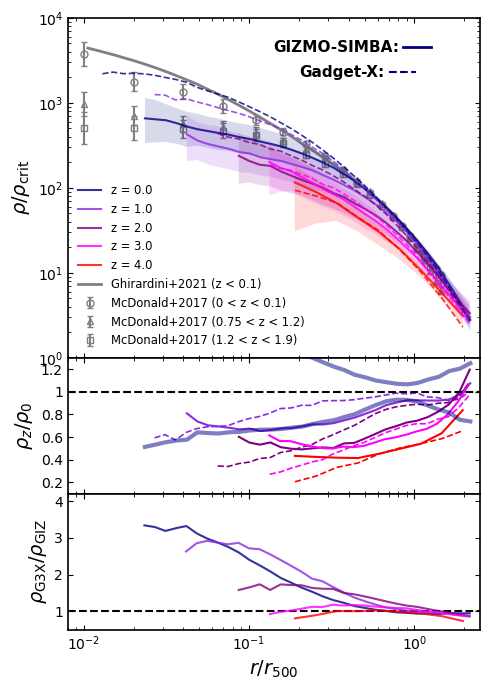

In [18]:
#Combined results
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (5,7), dpi = 100)
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.2 #set the value globally
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((9,4),(0,0),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((9,4),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((9,4),(7,0),colspan = 4,rowspan = 2)


snapb = [128,96,78,65,55,47,40]
redb = ['z = 0.0','z = 1.0','z = 2.0','z = 3.0','z = 4.0','z = 5.0','z = 6.0']
# colall = ['b','r','k','orange','cyan','magenta','green']
colall = ['navy','blueviolet','purple','magenta','r','tomato','orange']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]
#==========================================================

for i in [0,1,2,3,4]:
    if i == 0:
        xmed0,ymed0,yerr0,np_med0 = cal_sta_profiles('GIZ',GIZd,snapb[i],'Gdens',False,nGIZ[i])
        xmed25,ymed25,yerr25,np_med25 = cal_sta_profiles('GIZ',GIZd,snapb[i],'Gdens',True,nGIZ[i])
        idt = np.where(np_med0 >= 10)[0]
        ax1.plot(xmed0[idt],ymed0[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha=0.8)
        ax1.fill_between(xmed0[idt],yerr0[0,idt],yerr0[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed0[idt],yerr0[0,idt]/ymed0[idt],lw = 3, c='navy', ls = '-', alpha = 0.5, zorder = 500)
        ax10.plot(xmed0[idt],yerr0[1,idt]/ymed0[idt],lw = 3, c='navy', ls = '-', alpha = 0.5, zorder = 500)
        
        xmed0_x,ymed0_x,yerr0_x,np_med0_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Gdens',False,nG3X[i])
        xmed25_x,ymed25_x,yerr25_x,np_med25_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Gdens',True,nG3X[i])
        idt_x = np.where(np_med0_x >= 10)[0]
        ax1.plot(xmed0_x[idt_x],ymed0_x[idt_x],lw = 1.2, ls = '--',  c=colall[i], zorder = 30,alpha = 0.8)
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed0_x[idt_x],ymed0_x[idt_x]/ymed0[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed0_x[idt],ymed0_x[idt]/ymed0[idt], c=colall[i], zorder = 30,alpha = 0.8)
        # ax20.plot(xmed0_x[idt_x],ymed0_x[idt_x]/ymed0[idt_x], c=colall[i], zorder = 30,alpha = 0.8)

#         print('GIZ radius',xmed0[idt])
#         print('G3X radius',xmed0_x[idt_x])
        
    elif i <= 3:
        xmed,ymed,yerr,np_med = cal_sta_profiles('GIZ',GIZd,snapb[i],'Gdens',False,nGIZ[i])
        idt = np.where(np_med >= 10)[0]
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed0[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x,np_med_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Gdens',False,nG3X[i])
        idt_x = np.where(np_med_x >= 10)[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x], ymed_x[idt_x]/ymed0_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed_x[idt],ymed_x[idt]/ymed[idt], c=colall[i], zorder = 30,alpha = 0.8)
        
    else:
        xmed,ymed,yerr,np_med = cal_sta_profiles('GIZ',GIZd,snapb[i],'Gdens',True,nGIZ[i])
        idt = np.where(np_med >= 10)[0]
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color =colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed25[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x,np_med_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Gdens',True,nG3X[i])
        idt_x = np.where(np_med_x >= 10)[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed25_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        # ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed_x[idt],ymed_x[idt]/ymed[idt], c=colall[i], zorder = 30,alpha = 0.8)
        # print(np.where(yerr[0] > 0)[0].shape, np.where(yerr_x[0] != 0)[0].shape)
    # print(idt[idt == True].shape)

#========================================================================
ax1.text(0.14,4e3,'GIZMO-SIMBA:',weight = 'bold',size = 11) 
ax1.text(0.2,2e3,'Gadget-X:',weight = 'bold',size = 11) 

from matplotlib.lines import Line2D
lin1 = Line2D([],[],c = 'navy',lw = 2)
legend2 = ax1.legend(handles=[lin1],frameon = False, loc = (0.80,0.875))
ax1.add_artist(legend2)

lin0 = Line2D([],[],c = 'navy',lw = 1.5, ls = '--')
legend0 = ax1.legend(handles=[lin0],frameon = False, loc = (0.765,0.80))
ax1.add_artist(legend0)


ob1, ob2, ob3, ob4 = ob_Gdens(ax1)
# legend_ob = ax1.legend(handles=[ob1,ob2,ob3,ob4],frameon = False, loc = (0.765,0.20))
# ax1.add_artist(legend_ob)
#==========================================================================

ax10.axhline(1,c='k',ls='--')
ax1.legend(ncol = 1, loc = 3, fontsize = 'small', frameon = False)
ax1.set_ylabel(r'$\rho/\rho_{\rm crit}$', fontsize = 14)
ax1.loglog()
ax1.set_xticklabels([])
ax1.tick_params(top = 'on', right = 'on', which='both',direction = 'in', labelsize = 10)
# ax1.set_xticks()
ax1.set_ylim(1e0,1e4)
ax1.set_xlim(0.008,2.5)

ax10.set_xscale('log')
ax10.set_xlim(0.008,2.5)
ax10.set_ylim(0.1,1.3)
ax10.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
ax10.set_yticklabels([0.2,0.4,0.6,0.8,1,1.2])
# ax10.set_xlabel(r'$r/r_{500}$', fontsize = 14)
ax10.set_ylabel(r'$\rho_z/\rho_0$', fontsize = 14)
ax10.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)

ax20.axhline(1,c='k',ls='--')
ax20.set_xscale('log')
ax20.set_xlim(0.008,2.5)
ax20.set_ylim(0.5,4.2)
# ax10.set_yticks([0.2,0.4,0.6,0.8,1])
# ax10.set_yticklabels([0.2,0.4,0.6,0.8,1])
ax20.set_xlabel(r'$r/r_{500}$', fontsize = 14)
ax20.set_ylabel(r'$\rho_{\rm G3X}/\rho_{\rm GIZ}$', fontsize = 14)
ax20.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)

# ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
# ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
plt.tight_layout()
plt.subplots_adjust(wspace =0 ,hspace = 0)

# plt.savefig('./figsv2/Gdens.pdf')
# [37,31,26,21,9,7,7]

In [6]:
plt.figure()

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

def cal_one_profiles(mod,d,snap,region,pty,nclu,part = 0):
    nbin = 150
    allvalue=np.zeros(shape = (nbin))
    rbinvalue=np.zeros(shape = (nbin))
    npvalue=np.zeros(shape = (nbin))
    
    r500 = d['NewMDCLUSTER_%04d_%s/snap_%03d'%(nclu+1,pty,snap)].attrs['r500']
    allvalue = d['NewMDCLUSTER_%04d_%s/snap_%03d/%s'%(nclu+1,pty,snap,region)][:]
    rbinvalue = d['NewMDCLUSTER_%04d_%s/snap_%03d/Rbin'%(nclu+1,pty,snap)][:] / r500 #unit: r/r500
    return rbinvalue,allvalue

GIZd = h5py.File('./data/test/GIZ-profiles-evoz_clu1.hdf5','r')

pcri = cosmo.critical_density(0).to('kpc-3Msun').value / 0.6777**2
xmed,ymed = cal_one_profiles('GIZ',GIZd,128,'Gdens','delaytime',nclu = 0)
print(ymed)
plt.plot(xmed,ymed/pcri,c='b',label = 'z = 0 (DelayTime<=0)',alpha = 0.4)

#z = 1.076
pcri = cosmo.critical_density(1.076).to('kpc-3Msun').value / 0.6777**2 / (1 + 1.076)**3
xmed,ymed = cal_one_profiles('GIZ',GIZd,95,'Gdens','delaytime',nclu = 0)
plt.plot(xmed,ymed/pcri,c='r',label = 'z = 1.076 (DelayTime<=0)',alpha = 0.4)

#z = 2.021
pcri = cosmo.critical_density(2.021).to('kpc-3Msun').value / 0.6777**2 / (1 + 2.021)**3
xmed,ymed = cal_one_profiles('GIZ',GIZd,78,'Gdens','delaytime',nclu = 0)
plt.plot(xmed,ymed/pcri,c='k',label = 'z = 2.021 (DelayTime<=0)',alpha = 0.4)
#--------------------------------------------

pcri = cosmo.critical_density(0).to('kpc-3Msun').value / 0.6777**2
xmed,ymed = cal_one_profiles('GIZ',GIZd,128,'Gdens','nodelaytime',nclu = 0)
plt.plot(xmed,ymed/pcri,c='b',label = 'z = 0',ls = '--')

#z = 1.076
pcri = cosmo.critical_density(1.076).to('kpc-3Msun').value / 0.6777**2 / (1 + 1.076)**3
xmed,ymed = cal_one_profiles('GIZ',GIZd,95,'Gdens','nodelaytime',nclu = 0)
plt.plot(xmed,ymed/pcri,c='r',label = 'z = 1.076',ls = '--')

#z = 2.021
pcri = cosmo.critical_density(2.021).to('kpc-3Msun').value / 0.6777**2 / (1 + 2.021)**3
xmed,ymed = cal_one_profiles('GIZ',GIZd,78,'Gdens','nodelaytime',nclu = 0)
plt.plot(xmed,ymed/pcri,c='k',label = 'z = 2.021', ls = '--')
#--------------------------------------------
GIZd.close()

plt.title('Cluster 1')
plt.text(0.2,3e3,'GIZMO',weight = 'bold',size = 11)
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$\rho/\rho_{\rm crit}$')
plt.loglog()
plt.legend(fontsize = 'x-small')
plt.ylim(1e0,1e4)
plt.xlim(0.008,3)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.84220824e+06 0.00000000e+00 0.00000000e+00
 5.25017768e+05 0.00000000e+00 3.98215747e+05 0.00000000e+00
 7.96912910e+05 2.52968734e+05 0.00000000e+00 0.00000000e+00
 1.64090720e+05 1.41519160e+05 1.21861358e+05 2.20454390e+05
 2.27809046e+05 7.84047834e+04 2.09394233e+05 0.00000000e+00
 1.80923902e+05 2.28723806e+05 1.15724701e+05 2.18880623e+05
 1.88198869e+05 1.98892472e+05 4.27109619e+04 1.30674028e+05
 1.58855572e+05 1.67470462e+05 1.33441344e+05 1.01608091e+05
 1.94338641e+05 9.30096773e+04 1.82467144e+05 1.09199752e+05
 1.21125869e+05 1.54978848e+05 1.62097388e+05 1.25397935e+05
 1.24377403e+05 1.143915

In [7]:
def ob_Gdens():

    #McDonald+2017
    #SPT-Hiz: 1.2 < z < 1.9 (1.4e14 Msun/h < M500 < 2.8e14 Msun/h)
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    # 0 < z < 0.1
    pcri = np.log10(2.775 * 1e11 / 1e9 * 0.7**2) #Msunkpc-3
    x = np.array([0.01,0.02,0.04,0.07,0.11,0.16,0.22,0.29,0.37,0.45,0.54,0.64,0.74,0.84,0.94,1.04,1.15,1.25,1.35,1.45])
    y = np.array([3.57,3.25,3.13,2.96,2.80,2.66,2.52,2.37,2.21,2.06,1.92,1.79,1.67,1.55,1.43,1.32,1.22,1.12,1.04,0.97])
    y = y
    yer = np.array([0.14,0.11,0.09,0.08,0.06,0.04,0.03,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.02,0.02,0.02])
    plt.errorbar(x,10**y,yerr = [10**y-10**(y-yer), 10**(y+yer)-10**y], c = 'b',fmt = 'o',mfc = 'none', label = 'McDonald+2017 (0 < z < 0.1)'
                 ,ms = 5, zorder = 20, capsize = 2)

    
    # 0.75 < z < 1.2
    pcri = np.log10(cosmo.critical_density(1).to('Mpc-3Msun').value / 1e9) #Msunkpc-3
    x = np.array([0.01,0.02,0.04,0.07,0.11,0.16,0.22,0.29,0.37,0.45,0.54,0.64,0.74,0.84,0.94,1.04,1.15,1.25,1.35,1.45])
    y = np.array([2.99,2.85,2.75,2.71,2.65,2.55,2.46,2.36,2.21,2.09,1.96,1.82,1.68,1.55,1.41,1.28,1.15,1.02,0.90,0.79])
    y = y
    yer = np.array([0.14,0.11,0.09,0.08,0.06,0.04,0.03,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.03,0.03,0.04,0.04])
    plt.errorbar(x,10**y,yerr = [10**y-10**(y-yer), 10**(y+yer)-10**y], c = 'r',fmt = 'o', mfc = 'none', label = 'McDonald+2017 (0.75 < z < 1.2)'
                 ,ms = 5, zorder = 20, capsize = 2)
    
    #1.2 < z < 1.9
    pcri = np.log10(cosmo.critical_density(1).to('Mpc-3Msun').value / 1e9) #Msunkpc-3
    x = np.array([0.01,0.02,0.04,0.07,0.11,0.16,0.22,0.29,0.37,0.45,0.54,0.64,0.74,0.84,0.94,1.04,1.15,1.25,1.35,1.45])
    y = np.array([2.70,2.70,2.69,2.67,2.62,2.53,2.39,2.28,2.16,2.05,1.93,1.78,1.66,1.54,1.41,1.29,1.18,1.07,0.97,0.88])
    y = y
    yer = np.array([0.19,0.14,0.11,0.09,0.07,0.05,0.04,0.03,0.03,0.03,0.02,0.01,0.01,0.02,0.04,0.05,0.06,0.08,0.09,0.10])
    plt.errorbar(x,10**y,yerr = [10**y-10**(y-yer), 10**(y+yer)-10**y], c = 'k',fmt = 'o',mfc = 'none', label = 'McDonald+2017 (1.2 < z < 1.9)'
                 ,ms = 5, zorder = 20, capsize = 2)
    
    
    #------------------------------------------------------------------------------------------------
    
    #Ghirardini+2021
    #Mass range: M500 > 3e14 Msun
    G2021 = np.loadtxt(open('./data/ob_Gdens/Ghirardini+2021_X-COP.csv', 'r'),delimiter = ',')
    plt.plot(G2021[:,0], G2021[:,1], c = 'magenta', ls = '--', label = 'Ghirardini+2021 (z < 0.1)', lw =2 , zorder = 100)
    
    SPT0205 = np.loadtxt(open('./data/ob_Gdens/Ghirardini+2021_SPT-CLJ0205-5829.csv', 'r'),delimiter = ',')
    plt.plot(SPT0205[:,0], SPT0205[:,1], c = 'orange', ls = '--', label = 'SPT-CLJ0205-5829 (z = 1.3)', lw = 2, zorder = 101)
    
#     #------------------------------------------------------------------------------------------------
    
    #Ruppin+2021
    #Mass range: M500 < 2e14 Msun
    R2021 = np.loadtxt(open('./data/ob_Gdens/Ruppin+2021.csv', 'r'),delimiter = ',')
    plt.plot(R2021[:,0], R2021[:,1], 'c--', label = 'Ruppin+2021 (z > 0.5)', lw = 2, zorder = 102)
#     def Vmodel(xx,n0,rc,rs,alpha,beta,sg):
#         n0 = 10**n0
#         rc = 10**rc
#         rs = 10**rs
#         a1 = n0**2*(xx/rc)**(-alpha)
#         b1 = (1 + (xx/rc)**2)**(3*beta-alpha/2)
#         b2 = (1 + (xx/rs)**3)**(sg/3)
#         return a1/b1/b2
#     xx = np.linspace(10,1000,100)
#     CLJ0205 = Vmodel(xx,-4.87,2.1,5.6,1.1,0,6.2)
#     plt.plot(xx/1000,CLJ0205,'r--',label = 'CLJ0205')

plt.figure()

ob_Gdens()

plt.title('gas density (observations)')
plt.xlabel(r'$r/r_{500}$')
# plt.ylabel(r'$\rho[M_{\odot}kpc^{-3}]$')
plt.ylabel(r'$\rho/\rho_{\rm crit}$')
plt.loglog()
plt.legend(fontsize = 'small')
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
#gas density
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (9.5,4.5))
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

plt.subplot(121)
 
#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Gdens',324)
plt.plot(xmed,ymed,c='b',label = 'z = 0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'b',alpha = 0.25)

#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,96,'Gdens',324)
plt.plot(xmed,ymed,c='r',label = 'z = 1.0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'r',alpha = 0.25)

#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'Gdens',324)
plt.plot(xmed,ymed,c='k',label = 'z = 2.0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'k',alpha = 0.25)

ob_Gdens()

plt.text(0.6,3e3,'GIZMO',weight = 'bold',size = 11)
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$\rho/\rho_{\rm crit}$')
plt.loglog()
plt.legend(fontsize = 'x-small')
plt.ylim(1e0,1e4)
plt.xlim(0.008,3)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

#Gadget-X
plt.subplot(122)
#z = 0
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,128,'Gdens',324)
plt.plot(xmed,ymed,c='b',label = 'z = 0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'b',alpha = 0.25)

#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,96,'Gdens',324)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'r',alpha = 0.25)

#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,78,'Gdens',324)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'k',alpha = 0.25)

ob_Gdens()

plt.text(0.5,3e3,'Gadget-X',weight = 'bold',size = 11)
plt.xlabel(r'$r/r_{500}$')

plt.ylabel(r'$\rho/\rho_{\rm crit}$')
plt.loglog()
# plt.legend(fontsize = 'x-small')
plt.grid(c = 'grey', ls = '--', alpha = 0.5)
plt.ylim(1e0,1e4)
plt.xlim(0.008,3)
plt.savefig('./figs/Gdens.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

TypeError: cal_sta_profiles() missing 1 required positional argument: 'ntclu'

<IPython.core.display.Javascript object>


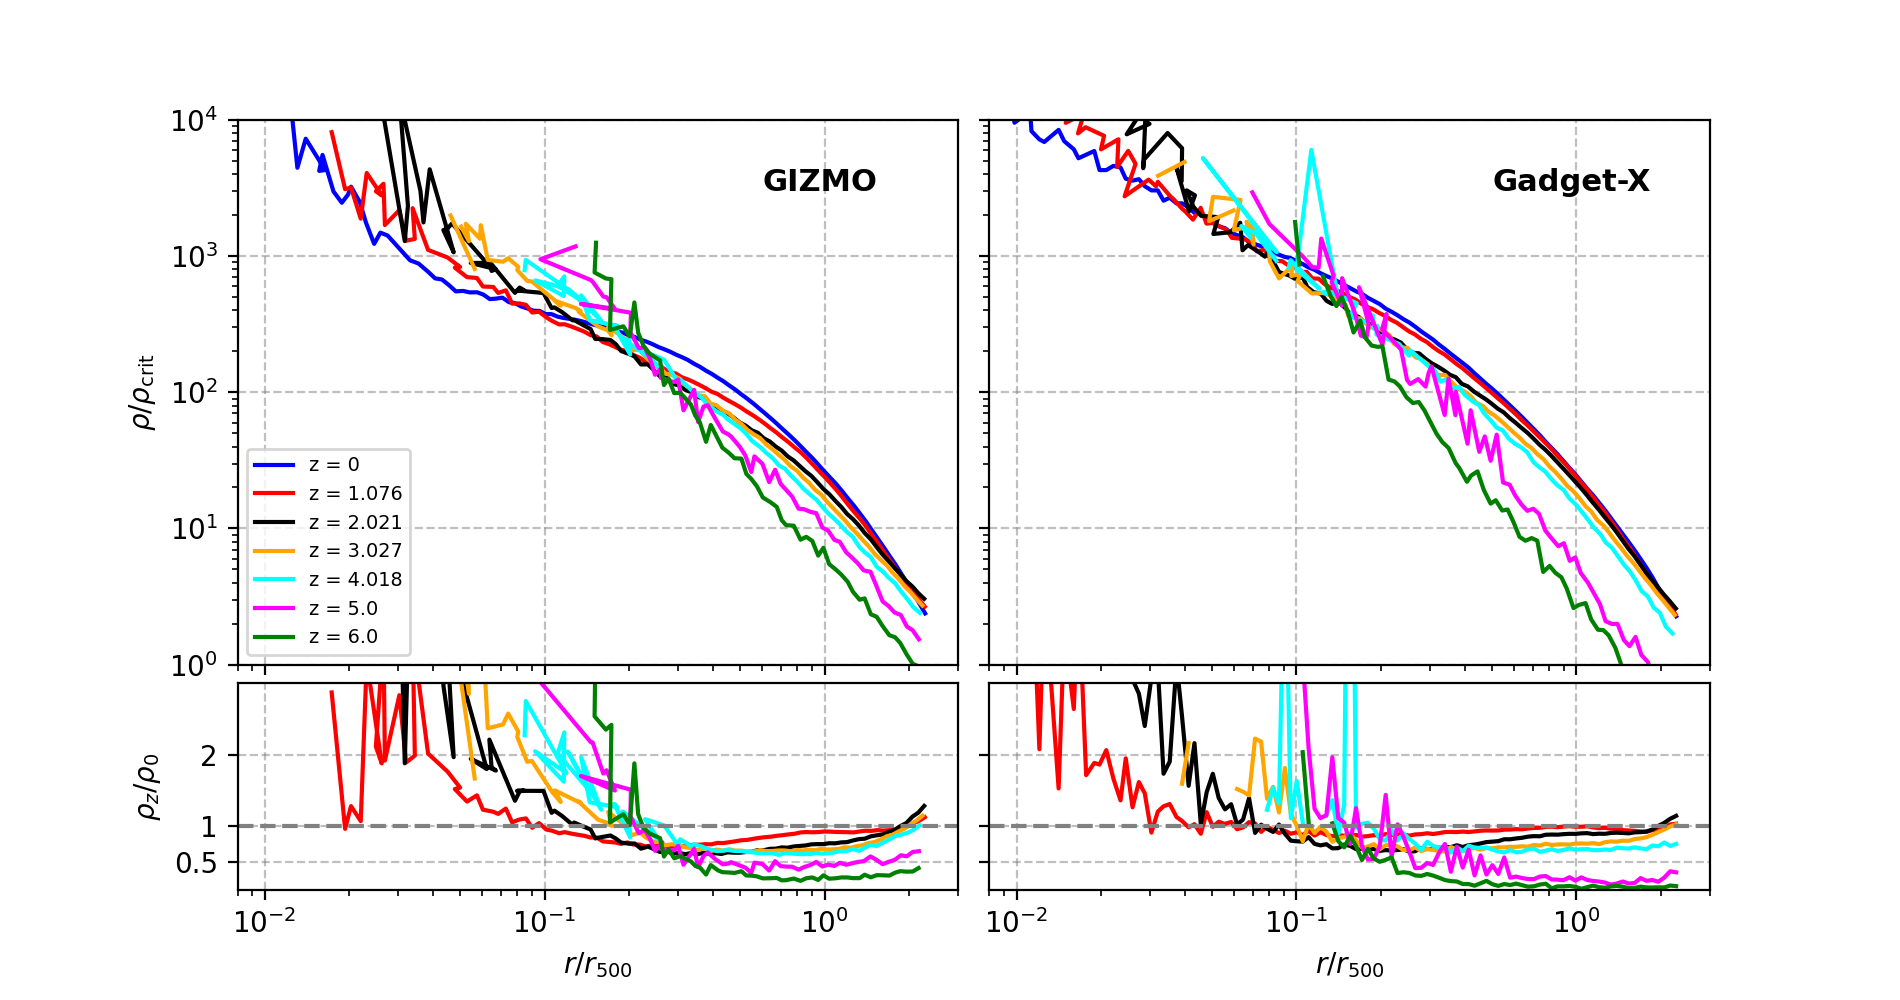

0.0
324
1.076147198677063


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324
2.0213561058044434


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323
3.0278635025024414
323

/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



4.017714977264404


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323
4.993260860443115


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


318
5.993073463439941
306

/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



0.0


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324
1.076147198677063
324

/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



2.0213561058044434


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324
3.0278635025024414
323

/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



4.017714977264404


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323
4.993260860443115
320

/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



5.993073463439941
305

/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]

In [13]:
#study evolution of gas density
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (9.5,5))
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((7,8),(0,0),colspan = 4,rowspan = 5)
ax2 = plt.subplot2grid((7,8),(0,4),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((7,8),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((7,8),(5,4),colspan = 4,rowspan = 2)

snapb = [128,95,78,65,55,47,40]
redb = ['z = 0','z = 1.076','z = 2.021','z = 3.027','z = 4.018','z = 5.0','z = 6.0']
colall = ['b','r','k','orange','cyan','magenta','green']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]

for i in range(7):
    if i == 0:
        xmed0,ymed0,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'Gdens',nGIZ[i])
        ax1.plot(xmed0,ymed0,label = redb[i],c=colall[i])
    else:
        xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'Gdens',nGIZ[i])
        ax1.plot(xmed,ymed,label = redb[i],c=colall[i])
        ax10.plot(xmed,ymed/ymed0,c=colall[i])
    # plt.fill_between(xmed,yerr[0],yerr[1],alpha = 0.25)

ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='grey',ls='--')

ax1.text(0.6,3e3,'GIZMO',weight = 'bold',size = 11)
ax1.set_ylabel(r'$\rho/\rho_{\rm crit}$')
ax1.loglog()
ax1.legend(fontsize = 'x-small', loc = 3)
ax1.axes.xaxis.set_ticklabels([])
ax1.set_ylim(1e0,1e4)
ax1.set_xlim(0.008,3)
ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(0.008,3)
ax10.set_ylim(0.1,3)
ax10.set_yticks([0.5,1,2])
ax10.set_yticklabels([0.5,1,2])
ax10.set_xlabel(r'$r/r_{500}$')
ax10.set_ylabel(r'$\rho_z/\rho_0$')

#Gadget-X
for i in range(7):
    if i == 0:
        xmed0,ymed0,yerr = cal_sta_profiles('G3X',G3Xd,snapb[i],'Gdens',nG3X[i])
        ax2.plot(xmed0,ymed0,label = redb[i],c=colall[i])
    else:
        xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,snapb[i],'Gdens',nG3X[i])
        ax2.plot(xmed,ymed,label = redb[i],c=colall[i])
        ax20.plot(xmed0,ymed/ymed0,c=colall[i])
    # plt.fill_between(xmed,yerr[0],yerr[1],alpha = 0.25)

ax20.grid(c = 'grey', ls = '--', alpha = 0.5)
ax20.axhline(1,c='grey',ls='--')
ax2.text(0.5,3e3,'Gadget-X',weight = 'bold',size = 11)

ax2.loglog()
ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])
ax2.grid(c = 'grey', ls = '--', alpha = 0.5)
ax2.set_ylim(1e0,1e4)
ax2.set_xlim(0.008,3)

ax20.set_xscale('log')
ax20.set_xlim(0.008,3)
ax20.set_ylim(0.1,3)
ax20.set_xlabel(r'$r/r_{500}$')
ax20.set_yticks([0.5,1,2])
ax20.axes.yaxis.set_ticklabels([])
# plt.savefig('./figs/Gdens.pdf')
# plt.tight_layout()

Improve figures